In [1]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.optimizer import Optimizer
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, _LRScheduler
import torch.nn.utils.weight_norm as weightNorm
import torch.nn.init as init
from torch.nn.parallel.data_parallel import data_parallel

from models.model import *
import torchvision.models as models

from utils.transform import *

from tensorboardX import SummaryWriter
from apex import amp
from ranger import *

import albumentations
from albumentations import torch as AT

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

In [2]:
############################################################################## Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

# If you try to use original LyftDataset Class, you will get missing table error
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

level5data = LyftTestDataset(data_path='.', json_path='/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/data', verbose=True)

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 1.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.6 seconds.


In [3]:
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

In [4]:
SIZE = 336

def transform_train(image, mask):
    if random.random() < 0.5:
        image = albumentations.RandomRotate90(p=1)(image=image)['image']
        mask = albumentations.RandomRotate90(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.Transpose(p=1)(image=image)['image']
        mask = albumentations.Transpose(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.VerticalFlip(p=1)(image=image)['image']
        mask = albumentations.VerticalFlip(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.HorizontalFlip(p=1)(image=image)['image']
        mask = albumentations.HorizontalFlip(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.15, rotate_limit=45, p=1)(image=image)['image']
    #     mask = albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.15, rotate_limit=45, p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.RandomBrightness(0.1)(image=image)['image']
        image = albumentations.RandomContrast(0.1)(image=image)['image']
        image = albumentations.Blur(blur_limit=3)(image=image)['image']

    # if random.random() < 0.5:
    #     image = albumentations.Cutout(num_holes=1, max_h_size=32, max_w_size=32, p=1)(image)
    #     mask = albumentations.Cutout(num_holes=1, max_h_size=32, max_w_size=32, p=1)(mask)

    return image, mask

def transform_valid(image, mask):
    # if random.random() < 0.5:
    #     image = albumentations.RandomRotate90(p=1)(image=image)['image']
    #     mask = albumentations.RandomRotate90(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.Transpose(p=1)(image=image)['image']
    #     mask = albumentations.Transpose(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.VerticalFlip(p=1)(image=image)['image']
    #     mask = albumentations.VerticalFlip(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.HorizontalFlip(p=1)(image=image)['image']
        mask = albumentations.HorizontalFlip(p=1)(image=mask)['image']

    return image, mask

def transform_test(image):
    
    image_hard = image.copy()
    image_simple = image.copy()

    if random.random() < 0.5:
        image_hard = albumentations.RandomBrightness(0.1)(image=image_hard)['image']
        image_hard = albumentations.RandomContrast(0.1)(image=image_hard)['image']
        image_hard = albumentations.Blur(blur_limit=3)(image=image_hard)['image']

    return image_simple, image_hard

In [5]:
class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths=None, target_filepaths=None, type="train", img_size=336, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.type = type
        self.map_filepaths = map_filepaths
        self.img_size = img_size
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        if (self.type != "test"):
            assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)

        if (self.target_filepaths):
            target_filepath = self.target_filepaths[idx]
            target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
            target = target.astype(np.int64)
        else:
            target = None

        if (self.type == "train"):
            im, target = transform_train(im, target)
        elif (self.type == "valid"):
            im, target = transform_valid(im, target)
        else:
            im, _ = transform_test(im) # im_simple, im_hard
        
        im = torch.from_numpy(im.transpose(2,0,1))

        if (self.type != "test"):
            target = torch.from_numpy(target)
            return im, target, sample_token
        else:
            return im, sample_token

In [6]:
class_height = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}

class_width = {'animal':0.36,'bicycle':0.63,'bus':2.96,'car':1.93,'emergency_vehicle':2.45,'motorcycle':0.96,
                'other_vehicle':2.79,'pedestrian':0.77,'truck':2.84}

class_len = {'animal':0.73,'bicycle':1.76,'bus':12.34,'car':4.76,'emergency_vehicle':6.52,'motorcycle':2.35,
                'other_vehicle':8.20,'pedestrian':0.81,'truck':10.24}



test_data_folder = "/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/bev_data/"

test_input_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_input.png")))
test_target_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_target.png")))

test_dataset = BEVImageDataset(input_filepaths=test_input_filepaths, target_filepaths=test_target_filepaths, type="test", img_size=SIZE, map_filepaths=None)

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
background_threshold = 40

def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes


def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [8]:
def get_unet_model(model_name="efficient-b3", IN_CHANNEL=3, NUM_CLASSES=2, SIZE=336):
    model = model_iMet(model_name, IN_CHANNEL, NUM_CLASSES, SIZE)
    
    # Optional, for multi GPU training and inference
    # model = nn.DataParallel(model)
    return model

# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

test_batch_size = 64

In [9]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=os.cpu_count()*2)

# Inference with efficientnet-b3 and seresnext_101

In [10]:
checkpoint_filename_b3 = "unet_checkpoint_b3/unet_checkpoint_b3.pth"
checkpoint_filepath_b3 = os.path.join("/media/jionie/my_disk/Kaggle/Lyft/model/unet/", checkpoint_filename_b3)

model_b3 = get_unet_model(model_name="efficientnet-b3", IN_CHANNEL=3, NUM_CLASSES=len(classes)+1, SIZE=SIZE)
model_b3.load_pretrain(checkpoint_filepath_b3)
model_b3 = model_b3.to(device)

Loaded pretrained weights for efficientnet-b3


In [11]:
checkpoint_filename_seresnext101 = "unet_checkpoint_seresnext101/seresnext101_unet_checkpoint.pth"
checkpoint_filepath_seresnext101 = os.path.join("/media/jionie/my_disk/Kaggle/Lyft/model/unet/", checkpoint_filename_seresnext101)

model_seresnext101 = get_unet_model(model_name="seresnext101", IN_CHANNEL=3, NUM_CLASSES=len(classes)+1, SIZE=SIZE)
model_seresnext101.load_pretrain(checkpoint_filepath_seresnext101)
model_seresnext101 = model_seresnext101.to(device)

In [12]:
sample_tokens = []
detection_boxes = []
detection_scores = []
detection_classes = []

print("Inference")

with torch.no_grad():
    
    torch.cuda.empty_cache()

    for test_batch_i, (X, sample_ids) in enumerate(test_dataloader):

        model_b3.eval()
        model_seresnext101.eval()

        sample_tokens.extend(sample_ids)

        X = X.to(device).float()  # [N, 3, H, W]
        prediction_b3, _ = model_b3(X)  # [N, 2, H, W]
        prediction_seresnext101, _ = model_seresnext101(X)  # [N, 2, H, W]
        
        prediction = (prediction_b3 + prediction_seresnext101) / 2
        
        prediction = F.softmax(prediction, dim=1).cpu().numpy()
        
        predictions = np.round(prediction*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:, 0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i], predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)

Inference


/home/jionie/py3env/lib/python3.6/site-packages/torch/nn/functional.py:2622: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Total amount of boxes: 686699


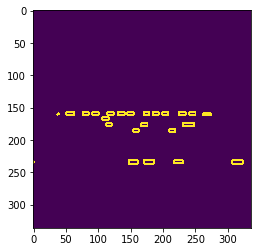

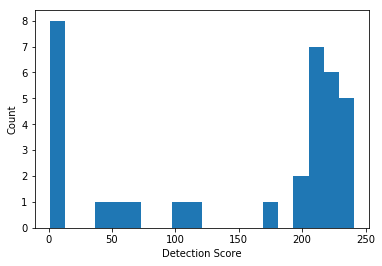

In [13]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

In [14]:
pred_box3ds = []

print("Generating world boxes")

# This could use some refactoring..
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in zip(sample_tokens, detection_boxes, detection_scores, detection_classes):

    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

    # box_height, width, len
    box_height = np.array([class_height[cls] for cls in sample_detection_class])
    box_width = np.array([class_width[cls] for cls in sample_detection_class])
    box_len = np.array([class_len[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:, 2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


Generating world boxes


In [15]:
sub = {}

print("Generating final csv")

for i in range(len(pred_box3ds)):

    if (i % 50 == 0):
        print("Generating ", i, " of ", len(pred_box3ds), " samples.")

    # yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0])

    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
        str(pred_box3ds[i].width) + ' ' + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + \
         str(yaw) + ' ' + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.to_csv('lyft3d_pred.csv',index=False)

Generating final csv
Generating  0  of  686699  samples.
Generating  50  of  686699  samples.
Generating  100  of  686699  samples.
Generating  150  of  686699  samples.
Generating  200  of  686699  samples.
Generating  250  of  686699  samples.
Generating  300  of  686699  samples.
Generating  350  of  686699  samples.
Generating  400  of  686699  samples.
Generating  450  of  686699  samples.
Generating  500  of  686699  samples.
Generating  550  of  686699  samples.
Generating  600  of  686699  samples.
Generating  650  of  686699  samples.
Generating  700  of  686699  samples.
Generating  750  of  686699  samples.
Generating  800  of  686699  samples.
Generating  850  of  686699  samples.
Generating  900  of  686699  samples.
Generating  950  of  686699  samples.
Generating  1000  of  686699  samples.
Generating  1050  of  686699  samples.
Generating  1100  of  686699  samples.
Generating  1150  of  686699  samples.
Generating  1200  of  686699  samples.
Generating  1250  of  68669

Generating  18350  of  686699  samples.
Generating  18400  of  686699  samples.
Generating  18450  of  686699  samples.
Generating  18500  of  686699  samples.
Generating  18550  of  686699  samples.
Generating  18600  of  686699  samples.
Generating  18650  of  686699  samples.
Generating  18700  of  686699  samples.
Generating  18750  of  686699  samples.
Generating  18800  of  686699  samples.
Generating  18850  of  686699  samples.
Generating  18900  of  686699  samples.
Generating  18950  of  686699  samples.
Generating  19000  of  686699  samples.
Generating  19050  of  686699  samples.
Generating  19100  of  686699  samples.
Generating  19150  of  686699  samples.
Generating  19200  of  686699  samples.
Generating  19250  of  686699  samples.
Generating  19300  of  686699  samples.
Generating  19350  of  686699  samples.
Generating  19400  of  686699  samples.
Generating  19450  of  686699  samples.
Generating  19500  of  686699  samples.
Generating  19550  of  686699  samples.


Generating  35100  of  686699  samples.
Generating  35150  of  686699  samples.
Generating  35200  of  686699  samples.
Generating  35250  of  686699  samples.
Generating  35300  of  686699  samples.
Generating  35350  of  686699  samples.
Generating  35400  of  686699  samples.
Generating  35450  of  686699  samples.
Generating  35500  of  686699  samples.
Generating  35550  of  686699  samples.
Generating  35600  of  686699  samples.
Generating  35650  of  686699  samples.
Generating  35700  of  686699  samples.
Generating  35750  of  686699  samples.
Generating  35800  of  686699  samples.
Generating  35850  of  686699  samples.
Generating  35900  of  686699  samples.
Generating  35950  of  686699  samples.
Generating  36000  of  686699  samples.
Generating  36050  of  686699  samples.
Generating  36100  of  686699  samples.
Generating  36150  of  686699  samples.
Generating  36200  of  686699  samples.
Generating  36250  of  686699  samples.
Generating  36300  of  686699  samples.


Generating  52800  of  686699  samples.
Generating  52850  of  686699  samples.
Generating  52900  of  686699  samples.
Generating  52950  of  686699  samples.
Generating  53000  of  686699  samples.
Generating  53050  of  686699  samples.
Generating  53100  of  686699  samples.
Generating  53150  of  686699  samples.
Generating  53200  of  686699  samples.
Generating  53250  of  686699  samples.
Generating  53300  of  686699  samples.
Generating  53350  of  686699  samples.
Generating  53400  of  686699  samples.
Generating  53450  of  686699  samples.
Generating  53500  of  686699  samples.
Generating  53550  of  686699  samples.
Generating  53600  of  686699  samples.
Generating  53650  of  686699  samples.
Generating  53700  of  686699  samples.
Generating  53750  of  686699  samples.
Generating  53800  of  686699  samples.
Generating  53850  of  686699  samples.
Generating  53900  of  686699  samples.
Generating  53950  of  686699  samples.
Generating  54000  of  686699  samples.


Generating  68300  of  686699  samples.
Generating  68350  of  686699  samples.
Generating  68400  of  686699  samples.
Generating  68450  of  686699  samples.
Generating  68500  of  686699  samples.
Generating  68550  of  686699  samples.
Generating  68600  of  686699  samples.
Generating  68650  of  686699  samples.
Generating  68700  of  686699  samples.
Generating  68750  of  686699  samples.
Generating  68800  of  686699  samples.
Generating  68850  of  686699  samples.
Generating  68900  of  686699  samples.
Generating  68950  of  686699  samples.
Generating  69000  of  686699  samples.
Generating  69050  of  686699  samples.
Generating  69100  of  686699  samples.
Generating  69150  of  686699  samples.
Generating  69200  of  686699  samples.
Generating  69250  of  686699  samples.
Generating  69300  of  686699  samples.
Generating  69350  of  686699  samples.
Generating  69400  of  686699  samples.
Generating  69450  of  686699  samples.
Generating  69500  of  686699  samples.


Generating  85350  of  686699  samples.
Generating  85400  of  686699  samples.
Generating  85450  of  686699  samples.
Generating  85500  of  686699  samples.
Generating  85550  of  686699  samples.
Generating  85600  of  686699  samples.
Generating  85650  of  686699  samples.
Generating  85700  of  686699  samples.
Generating  85750  of  686699  samples.
Generating  85800  of  686699  samples.
Generating  85850  of  686699  samples.
Generating  85900  of  686699  samples.
Generating  85950  of  686699  samples.
Generating  86000  of  686699  samples.
Generating  86050  of  686699  samples.
Generating  86100  of  686699  samples.
Generating  86150  of  686699  samples.
Generating  86200  of  686699  samples.
Generating  86250  of  686699  samples.
Generating  86300  of  686699  samples.
Generating  86350  of  686699  samples.
Generating  86400  of  686699  samples.
Generating  86450  of  686699  samples.
Generating  86500  of  686699  samples.
Generating  86550  of  686699  samples.


Generating  102000  of  686699  samples.
Generating  102050  of  686699  samples.
Generating  102100  of  686699  samples.
Generating  102150  of  686699  samples.
Generating  102200  of  686699  samples.
Generating  102250  of  686699  samples.
Generating  102300  of  686699  samples.
Generating  102350  of  686699  samples.
Generating  102400  of  686699  samples.
Generating  102450  of  686699  samples.
Generating  102500  of  686699  samples.
Generating  102550  of  686699  samples.
Generating  102600  of  686699  samples.
Generating  102650  of  686699  samples.
Generating  102700  of  686699  samples.
Generating  102750  of  686699  samples.
Generating  102800  of  686699  samples.
Generating  102850  of  686699  samples.
Generating  102900  of  686699  samples.
Generating  102950  of  686699  samples.
Generating  103000  of  686699  samples.
Generating  103050  of  686699  samples.
Generating  103100  of  686699  samples.
Generating  103150  of  686699  samples.
Generating  1032

Generating  118300  of  686699  samples.
Generating  118350  of  686699  samples.
Generating  118400  of  686699  samples.
Generating  118450  of  686699  samples.
Generating  118500  of  686699  samples.
Generating  118550  of  686699  samples.
Generating  118600  of  686699  samples.
Generating  118650  of  686699  samples.
Generating  118700  of  686699  samples.
Generating  118750  of  686699  samples.
Generating  118800  of  686699  samples.
Generating  118850  of  686699  samples.
Generating  118900  of  686699  samples.
Generating  118950  of  686699  samples.
Generating  119000  of  686699  samples.
Generating  119050  of  686699  samples.
Generating  119100  of  686699  samples.
Generating  119150  of  686699  samples.
Generating  119200  of  686699  samples.
Generating  119250  of  686699  samples.
Generating  119300  of  686699  samples.
Generating  119350  of  686699  samples.
Generating  119400  of  686699  samples.
Generating  119450  of  686699  samples.
Generating  1195

Generating  135700  of  686699  samples.
Generating  135750  of  686699  samples.
Generating  135800  of  686699  samples.
Generating  135850  of  686699  samples.
Generating  135900  of  686699  samples.
Generating  135950  of  686699  samples.
Generating  136000  of  686699  samples.
Generating  136050  of  686699  samples.
Generating  136100  of  686699  samples.
Generating  136150  of  686699  samples.
Generating  136200  of  686699  samples.
Generating  136250  of  686699  samples.
Generating  136300  of  686699  samples.
Generating  136350  of  686699  samples.
Generating  136400  of  686699  samples.
Generating  136450  of  686699  samples.
Generating  136500  of  686699  samples.
Generating  136550  of  686699  samples.
Generating  136600  of  686699  samples.
Generating  136650  of  686699  samples.
Generating  136700  of  686699  samples.
Generating  136750  of  686699  samples.
Generating  136800  of  686699  samples.
Generating  136850  of  686699  samples.
Generating  1369

Generating  153300  of  686699  samples.
Generating  153350  of  686699  samples.
Generating  153400  of  686699  samples.
Generating  153450  of  686699  samples.
Generating  153500  of  686699  samples.
Generating  153550  of  686699  samples.
Generating  153600  of  686699  samples.
Generating  153650  of  686699  samples.
Generating  153700  of  686699  samples.
Generating  153750  of  686699  samples.
Generating  153800  of  686699  samples.
Generating  153850  of  686699  samples.
Generating  153900  of  686699  samples.
Generating  153950  of  686699  samples.
Generating  154000  of  686699  samples.
Generating  154050  of  686699  samples.
Generating  154100  of  686699  samples.
Generating  154150  of  686699  samples.
Generating  154200  of  686699  samples.
Generating  154250  of  686699  samples.
Generating  154300  of  686699  samples.
Generating  154350  of  686699  samples.
Generating  154400  of  686699  samples.
Generating  154450  of  686699  samples.
Generating  1545

Generating  171250  of  686699  samples.
Generating  171300  of  686699  samples.
Generating  171350  of  686699  samples.
Generating  171400  of  686699  samples.
Generating  171450  of  686699  samples.
Generating  171500  of  686699  samples.
Generating  171550  of  686699  samples.
Generating  171600  of  686699  samples.
Generating  171650  of  686699  samples.
Generating  171700  of  686699  samples.
Generating  171750  of  686699  samples.
Generating  171800  of  686699  samples.
Generating  171850  of  686699  samples.
Generating  171900  of  686699  samples.
Generating  171950  of  686699  samples.
Generating  172000  of  686699  samples.
Generating  172050  of  686699  samples.
Generating  172100  of  686699  samples.
Generating  172150  of  686699  samples.
Generating  172200  of  686699  samples.
Generating  172250  of  686699  samples.
Generating  172300  of  686699  samples.
Generating  172350  of  686699  samples.
Generating  172400  of  686699  samples.
Generating  1724

Generating  188300  of  686699  samples.
Generating  188350  of  686699  samples.
Generating  188400  of  686699  samples.
Generating  188450  of  686699  samples.
Generating  188500  of  686699  samples.
Generating  188550  of  686699  samples.
Generating  188600  of  686699  samples.
Generating  188650  of  686699  samples.
Generating  188700  of  686699  samples.
Generating  188750  of  686699  samples.
Generating  188800  of  686699  samples.
Generating  188850  of  686699  samples.
Generating  188900  of  686699  samples.
Generating  188950  of  686699  samples.
Generating  189000  of  686699  samples.
Generating  189050  of  686699  samples.
Generating  189100  of  686699  samples.
Generating  189150  of  686699  samples.
Generating  189200  of  686699  samples.
Generating  189250  of  686699  samples.
Generating  189300  of  686699  samples.
Generating  189350  of  686699  samples.
Generating  189400  of  686699  samples.
Generating  189450  of  686699  samples.
Generating  1895

Generating  205800  of  686699  samples.
Generating  205850  of  686699  samples.
Generating  205900  of  686699  samples.
Generating  205950  of  686699  samples.
Generating  206000  of  686699  samples.
Generating  206050  of  686699  samples.
Generating  206100  of  686699  samples.
Generating  206150  of  686699  samples.
Generating  206200  of  686699  samples.
Generating  206250  of  686699  samples.
Generating  206300  of  686699  samples.
Generating  206350  of  686699  samples.
Generating  206400  of  686699  samples.
Generating  206450  of  686699  samples.
Generating  206500  of  686699  samples.
Generating  206550  of  686699  samples.
Generating  206600  of  686699  samples.
Generating  206650  of  686699  samples.
Generating  206700  of  686699  samples.
Generating  206750  of  686699  samples.
Generating  206800  of  686699  samples.
Generating  206850  of  686699  samples.
Generating  206900  of  686699  samples.
Generating  206950  of  686699  samples.
Generating  2070

Generating  223250  of  686699  samples.
Generating  223300  of  686699  samples.
Generating  223350  of  686699  samples.
Generating  223400  of  686699  samples.
Generating  223450  of  686699  samples.
Generating  223500  of  686699  samples.
Generating  223550  of  686699  samples.
Generating  223600  of  686699  samples.
Generating  223650  of  686699  samples.
Generating  223700  of  686699  samples.
Generating  223750  of  686699  samples.
Generating  223800  of  686699  samples.
Generating  223850  of  686699  samples.
Generating  223900  of  686699  samples.
Generating  223950  of  686699  samples.
Generating  224000  of  686699  samples.
Generating  224050  of  686699  samples.
Generating  224100  of  686699  samples.
Generating  224150  of  686699  samples.
Generating  224200  of  686699  samples.
Generating  224250  of  686699  samples.
Generating  224300  of  686699  samples.
Generating  224350  of  686699  samples.
Generating  224400  of  686699  samples.
Generating  2244

Generating  240650  of  686699  samples.
Generating  240700  of  686699  samples.
Generating  240750  of  686699  samples.
Generating  240800  of  686699  samples.
Generating  240850  of  686699  samples.
Generating  240900  of  686699  samples.
Generating  240950  of  686699  samples.
Generating  241000  of  686699  samples.
Generating  241050  of  686699  samples.
Generating  241100  of  686699  samples.
Generating  241150  of  686699  samples.
Generating  241200  of  686699  samples.
Generating  241250  of  686699  samples.
Generating  241300  of  686699  samples.
Generating  241350  of  686699  samples.
Generating  241400  of  686699  samples.
Generating  241450  of  686699  samples.
Generating  241500  of  686699  samples.
Generating  241550  of  686699  samples.
Generating  241600  of  686699  samples.
Generating  241650  of  686699  samples.
Generating  241700  of  686699  samples.
Generating  241750  of  686699  samples.
Generating  241800  of  686699  samples.
Generating  2418

Generating  258250  of  686699  samples.
Generating  258300  of  686699  samples.
Generating  258350  of  686699  samples.
Generating  258400  of  686699  samples.
Generating  258450  of  686699  samples.
Generating  258500  of  686699  samples.
Generating  258550  of  686699  samples.
Generating  258600  of  686699  samples.
Generating  258650  of  686699  samples.
Generating  258700  of  686699  samples.
Generating  258750  of  686699  samples.
Generating  258800  of  686699  samples.
Generating  258850  of  686699  samples.
Generating  258900  of  686699  samples.
Generating  258950  of  686699  samples.
Generating  259000  of  686699  samples.
Generating  259050  of  686699  samples.
Generating  259100  of  686699  samples.
Generating  259150  of  686699  samples.
Generating  259200  of  686699  samples.
Generating  259250  of  686699  samples.
Generating  259300  of  686699  samples.
Generating  259350  of  686699  samples.
Generating  259400  of  686699  samples.
Generating  2594

Generating  275750  of  686699  samples.
Generating  275800  of  686699  samples.
Generating  275850  of  686699  samples.
Generating  275900  of  686699  samples.
Generating  275950  of  686699  samples.
Generating  276000  of  686699  samples.
Generating  276050  of  686699  samples.
Generating  276100  of  686699  samples.
Generating  276150  of  686699  samples.
Generating  276200  of  686699  samples.
Generating  276250  of  686699  samples.
Generating  276300  of  686699  samples.
Generating  276350  of  686699  samples.
Generating  276400  of  686699  samples.
Generating  276450  of  686699  samples.
Generating  276500  of  686699  samples.
Generating  276550  of  686699  samples.
Generating  276600  of  686699  samples.
Generating  276650  of  686699  samples.
Generating  276700  of  686699  samples.
Generating  276750  of  686699  samples.
Generating  276800  of  686699  samples.
Generating  276850  of  686699  samples.
Generating  276900  of  686699  samples.
Generating  2769

Generating  293250  of  686699  samples.
Generating  293300  of  686699  samples.
Generating  293350  of  686699  samples.
Generating  293400  of  686699  samples.
Generating  293450  of  686699  samples.
Generating  293500  of  686699  samples.
Generating  293550  of  686699  samples.
Generating  293600  of  686699  samples.
Generating  293650  of  686699  samples.
Generating  293700  of  686699  samples.
Generating  293750  of  686699  samples.
Generating  293800  of  686699  samples.
Generating  293850  of  686699  samples.
Generating  293900  of  686699  samples.
Generating  293950  of  686699  samples.
Generating  294000  of  686699  samples.
Generating  294050  of  686699  samples.
Generating  294100  of  686699  samples.
Generating  294150  of  686699  samples.
Generating  294200  of  686699  samples.
Generating  294250  of  686699  samples.
Generating  294300  of  686699  samples.
Generating  294350  of  686699  samples.
Generating  294400  of  686699  samples.
Generating  2944

Generating  310550  of  686699  samples.
Generating  310600  of  686699  samples.
Generating  310650  of  686699  samples.
Generating  310700  of  686699  samples.
Generating  310750  of  686699  samples.
Generating  310800  of  686699  samples.
Generating  310850  of  686699  samples.
Generating  310900  of  686699  samples.
Generating  310950  of  686699  samples.
Generating  311000  of  686699  samples.
Generating  311050  of  686699  samples.
Generating  311100  of  686699  samples.
Generating  311150  of  686699  samples.
Generating  311200  of  686699  samples.
Generating  311250  of  686699  samples.
Generating  311300  of  686699  samples.
Generating  311350  of  686699  samples.
Generating  311400  of  686699  samples.
Generating  311450  of  686699  samples.
Generating  311500  of  686699  samples.
Generating  311550  of  686699  samples.
Generating  311600  of  686699  samples.
Generating  311650  of  686699  samples.
Generating  311700  of  686699  samples.
Generating  3117

Generating  328250  of  686699  samples.
Generating  328300  of  686699  samples.
Generating  328350  of  686699  samples.
Generating  328400  of  686699  samples.
Generating  328450  of  686699  samples.
Generating  328500  of  686699  samples.
Generating  328550  of  686699  samples.
Generating  328600  of  686699  samples.
Generating  328650  of  686699  samples.
Generating  328700  of  686699  samples.
Generating  328750  of  686699  samples.
Generating  328800  of  686699  samples.
Generating  328850  of  686699  samples.
Generating  328900  of  686699  samples.
Generating  328950  of  686699  samples.
Generating  329000  of  686699  samples.
Generating  329050  of  686699  samples.
Generating  329100  of  686699  samples.
Generating  329150  of  686699  samples.
Generating  329200  of  686699  samples.
Generating  329250  of  686699  samples.
Generating  329300  of  686699  samples.
Generating  329350  of  686699  samples.
Generating  329400  of  686699  samples.
Generating  3294

Generating  345450  of  686699  samples.
Generating  345500  of  686699  samples.
Generating  345550  of  686699  samples.
Generating  345600  of  686699  samples.
Generating  345650  of  686699  samples.
Generating  345700  of  686699  samples.
Generating  345750  of  686699  samples.
Generating  345800  of  686699  samples.
Generating  345850  of  686699  samples.
Generating  345900  of  686699  samples.
Generating  345950  of  686699  samples.
Generating  346000  of  686699  samples.
Generating  346050  of  686699  samples.
Generating  346100  of  686699  samples.
Generating  346150  of  686699  samples.
Generating  346200  of  686699  samples.
Generating  346250  of  686699  samples.
Generating  346300  of  686699  samples.
Generating  346350  of  686699  samples.
Generating  346400  of  686699  samples.
Generating  346450  of  686699  samples.
Generating  346500  of  686699  samples.
Generating  346550  of  686699  samples.
Generating  346600  of  686699  samples.
Generating  3466

Generating  363250  of  686699  samples.
Generating  363300  of  686699  samples.
Generating  363350  of  686699  samples.
Generating  363400  of  686699  samples.
Generating  363450  of  686699  samples.
Generating  363500  of  686699  samples.
Generating  363550  of  686699  samples.
Generating  363600  of  686699  samples.
Generating  363650  of  686699  samples.
Generating  363700  of  686699  samples.
Generating  363750  of  686699  samples.
Generating  363800  of  686699  samples.
Generating  363850  of  686699  samples.
Generating  363900  of  686699  samples.
Generating  363950  of  686699  samples.
Generating  364000  of  686699  samples.
Generating  364050  of  686699  samples.
Generating  364100  of  686699  samples.
Generating  364150  of  686699  samples.
Generating  364200  of  686699  samples.
Generating  364250  of  686699  samples.
Generating  364300  of  686699  samples.
Generating  364350  of  686699  samples.
Generating  364400  of  686699  samples.
Generating  3644

Generating  381850  of  686699  samples.
Generating  381900  of  686699  samples.
Generating  381950  of  686699  samples.
Generating  382000  of  686699  samples.
Generating  382050  of  686699  samples.
Generating  382100  of  686699  samples.
Generating  382150  of  686699  samples.
Generating  382200  of  686699  samples.
Generating  382250  of  686699  samples.
Generating  382300  of  686699  samples.
Generating  382350  of  686699  samples.
Generating  382400  of  686699  samples.
Generating  382450  of  686699  samples.
Generating  382500  of  686699  samples.
Generating  382550  of  686699  samples.
Generating  382600  of  686699  samples.
Generating  382650  of  686699  samples.
Generating  382700  of  686699  samples.
Generating  382750  of  686699  samples.
Generating  382800  of  686699  samples.
Generating  382850  of  686699  samples.
Generating  382900  of  686699  samples.
Generating  382950  of  686699  samples.
Generating  383000  of  686699  samples.
Generating  3830

Generating  398200  of  686699  samples.
Generating  398250  of  686699  samples.
Generating  398300  of  686699  samples.
Generating  398350  of  686699  samples.
Generating  398400  of  686699  samples.
Generating  398450  of  686699  samples.
Generating  398500  of  686699  samples.
Generating  398550  of  686699  samples.
Generating  398600  of  686699  samples.
Generating  398650  of  686699  samples.
Generating  398700  of  686699  samples.
Generating  398750  of  686699  samples.
Generating  398800  of  686699  samples.
Generating  398850  of  686699  samples.
Generating  398900  of  686699  samples.
Generating  398950  of  686699  samples.
Generating  399000  of  686699  samples.
Generating  399050  of  686699  samples.
Generating  399100  of  686699  samples.
Generating  399150  of  686699  samples.
Generating  399200  of  686699  samples.
Generating  399250  of  686699  samples.
Generating  399300  of  686699  samples.
Generating  399350  of  686699  samples.
Generating  3994

Generating  415300  of  686699  samples.
Generating  415350  of  686699  samples.
Generating  415400  of  686699  samples.
Generating  415450  of  686699  samples.
Generating  415500  of  686699  samples.
Generating  415550  of  686699  samples.
Generating  415600  of  686699  samples.
Generating  415650  of  686699  samples.
Generating  415700  of  686699  samples.
Generating  415750  of  686699  samples.
Generating  415800  of  686699  samples.
Generating  415850  of  686699  samples.
Generating  415900  of  686699  samples.
Generating  415950  of  686699  samples.
Generating  416000  of  686699  samples.
Generating  416050  of  686699  samples.
Generating  416100  of  686699  samples.
Generating  416150  of  686699  samples.
Generating  416200  of  686699  samples.
Generating  416250  of  686699  samples.
Generating  416300  of  686699  samples.
Generating  416350  of  686699  samples.
Generating  416400  of  686699  samples.
Generating  416450  of  686699  samples.
Generating  4165

Generating  433200  of  686699  samples.
Generating  433250  of  686699  samples.
Generating  433300  of  686699  samples.
Generating  433350  of  686699  samples.
Generating  433400  of  686699  samples.
Generating  433450  of  686699  samples.
Generating  433500  of  686699  samples.
Generating  433550  of  686699  samples.
Generating  433600  of  686699  samples.
Generating  433650  of  686699  samples.
Generating  433700  of  686699  samples.
Generating  433750  of  686699  samples.
Generating  433800  of  686699  samples.
Generating  433850  of  686699  samples.
Generating  433900  of  686699  samples.
Generating  433950  of  686699  samples.
Generating  434000  of  686699  samples.
Generating  434050  of  686699  samples.
Generating  434100  of  686699  samples.
Generating  434150  of  686699  samples.
Generating  434200  of  686699  samples.
Generating  434250  of  686699  samples.
Generating  434300  of  686699  samples.
Generating  434350  of  686699  samples.
Generating  4344

Generating  450550  of  686699  samples.
Generating  450600  of  686699  samples.
Generating  450650  of  686699  samples.
Generating  450700  of  686699  samples.
Generating  450750  of  686699  samples.
Generating  450800  of  686699  samples.
Generating  450850  of  686699  samples.
Generating  450900  of  686699  samples.
Generating  450950  of  686699  samples.
Generating  451000  of  686699  samples.
Generating  451050  of  686699  samples.
Generating  451100  of  686699  samples.
Generating  451150  of  686699  samples.
Generating  451200  of  686699  samples.
Generating  451250  of  686699  samples.
Generating  451300  of  686699  samples.
Generating  451350  of  686699  samples.
Generating  451400  of  686699  samples.
Generating  451450  of  686699  samples.
Generating  451500  of  686699  samples.
Generating  451550  of  686699  samples.
Generating  451600  of  686699  samples.
Generating  451650  of  686699  samples.
Generating  451700  of  686699  samples.
Generating  4517

Generating  467950  of  686699  samples.
Generating  468000  of  686699  samples.
Generating  468050  of  686699  samples.
Generating  468100  of  686699  samples.
Generating  468150  of  686699  samples.
Generating  468200  of  686699  samples.
Generating  468250  of  686699  samples.
Generating  468300  of  686699  samples.
Generating  468350  of  686699  samples.
Generating  468400  of  686699  samples.
Generating  468450  of  686699  samples.
Generating  468500  of  686699  samples.
Generating  468550  of  686699  samples.
Generating  468600  of  686699  samples.
Generating  468650  of  686699  samples.
Generating  468700  of  686699  samples.
Generating  468750  of  686699  samples.
Generating  468800  of  686699  samples.
Generating  468850  of  686699  samples.
Generating  468900  of  686699  samples.
Generating  468950  of  686699  samples.
Generating  469000  of  686699  samples.
Generating  469050  of  686699  samples.
Generating  469100  of  686699  samples.
Generating  4691

Generating  485400  of  686699  samples.
Generating  485450  of  686699  samples.
Generating  485500  of  686699  samples.
Generating  485550  of  686699  samples.
Generating  485600  of  686699  samples.
Generating  485650  of  686699  samples.
Generating  485700  of  686699  samples.
Generating  485750  of  686699  samples.
Generating  485800  of  686699  samples.
Generating  485850  of  686699  samples.
Generating  485900  of  686699  samples.
Generating  485950  of  686699  samples.
Generating  486000  of  686699  samples.
Generating  486050  of  686699  samples.
Generating  486100  of  686699  samples.
Generating  486150  of  686699  samples.
Generating  486200  of  686699  samples.
Generating  486250  of  686699  samples.
Generating  486300  of  686699  samples.
Generating  486350  of  686699  samples.
Generating  486400  of  686699  samples.
Generating  486450  of  686699  samples.
Generating  486500  of  686699  samples.
Generating  486550  of  686699  samples.
Generating  4866

Generating  502500  of  686699  samples.
Generating  502550  of  686699  samples.
Generating  502600  of  686699  samples.
Generating  502650  of  686699  samples.
Generating  502700  of  686699  samples.
Generating  502750  of  686699  samples.
Generating  502800  of  686699  samples.
Generating  502850  of  686699  samples.
Generating  502900  of  686699  samples.
Generating  502950  of  686699  samples.
Generating  503000  of  686699  samples.
Generating  503050  of  686699  samples.
Generating  503100  of  686699  samples.
Generating  503150  of  686699  samples.
Generating  503200  of  686699  samples.
Generating  503250  of  686699  samples.
Generating  503300  of  686699  samples.
Generating  503350  of  686699  samples.
Generating  503400  of  686699  samples.
Generating  503450  of  686699  samples.
Generating  503500  of  686699  samples.
Generating  503550  of  686699  samples.
Generating  503600  of  686699  samples.
Generating  503650  of  686699  samples.
Generating  5037

Generating  521500  of  686699  samples.
Generating  521550  of  686699  samples.
Generating  521600  of  686699  samples.
Generating  521650  of  686699  samples.
Generating  521700  of  686699  samples.
Generating  521750  of  686699  samples.
Generating  521800  of  686699  samples.
Generating  521850  of  686699  samples.
Generating  521900  of  686699  samples.
Generating  521950  of  686699  samples.
Generating  522000  of  686699  samples.
Generating  522050  of  686699  samples.
Generating  522100  of  686699  samples.
Generating  522150  of  686699  samples.
Generating  522200  of  686699  samples.
Generating  522250  of  686699  samples.
Generating  522300  of  686699  samples.
Generating  522350  of  686699  samples.
Generating  522400  of  686699  samples.
Generating  522450  of  686699  samples.
Generating  522500  of  686699  samples.
Generating  522550  of  686699  samples.
Generating  522600  of  686699  samples.
Generating  522650  of  686699  samples.
Generating  5227

Generating  538200  of  686699  samples.
Generating  538250  of  686699  samples.
Generating  538300  of  686699  samples.
Generating  538350  of  686699  samples.
Generating  538400  of  686699  samples.
Generating  538450  of  686699  samples.
Generating  538500  of  686699  samples.
Generating  538550  of  686699  samples.
Generating  538600  of  686699  samples.
Generating  538650  of  686699  samples.
Generating  538700  of  686699  samples.
Generating  538750  of  686699  samples.
Generating  538800  of  686699  samples.
Generating  538850  of  686699  samples.
Generating  538900  of  686699  samples.
Generating  538950  of  686699  samples.
Generating  539000  of  686699  samples.
Generating  539050  of  686699  samples.
Generating  539100  of  686699  samples.
Generating  539150  of  686699  samples.
Generating  539200  of  686699  samples.
Generating  539250  of  686699  samples.
Generating  539300  of  686699  samples.
Generating  539350  of  686699  samples.
Generating  5394

Generating  556900  of  686699  samples.
Generating  556950  of  686699  samples.
Generating  557000  of  686699  samples.
Generating  557050  of  686699  samples.
Generating  557100  of  686699  samples.
Generating  557150  of  686699  samples.
Generating  557200  of  686699  samples.
Generating  557250  of  686699  samples.
Generating  557300  of  686699  samples.
Generating  557350  of  686699  samples.
Generating  557400  of  686699  samples.
Generating  557450  of  686699  samples.
Generating  557500  of  686699  samples.
Generating  557550  of  686699  samples.
Generating  557600  of  686699  samples.
Generating  557650  of  686699  samples.
Generating  557700  of  686699  samples.
Generating  557750  of  686699  samples.
Generating  557800  of  686699  samples.
Generating  557850  of  686699  samples.
Generating  557900  of  686699  samples.
Generating  557950  of  686699  samples.
Generating  558000  of  686699  samples.
Generating  558050  of  686699  samples.
Generating  5581

Generating  574200  of  686699  samples.
Generating  574250  of  686699  samples.
Generating  574300  of  686699  samples.
Generating  574350  of  686699  samples.
Generating  574400  of  686699  samples.
Generating  574450  of  686699  samples.
Generating  574500  of  686699  samples.
Generating  574550  of  686699  samples.
Generating  574600  of  686699  samples.
Generating  574650  of  686699  samples.
Generating  574700  of  686699  samples.
Generating  574750  of  686699  samples.
Generating  574800  of  686699  samples.
Generating  574850  of  686699  samples.
Generating  574900  of  686699  samples.
Generating  574950  of  686699  samples.
Generating  575000  of  686699  samples.
Generating  575050  of  686699  samples.
Generating  575100  of  686699  samples.
Generating  575150  of  686699  samples.
Generating  575200  of  686699  samples.
Generating  575250  of  686699  samples.
Generating  575300  of  686699  samples.
Generating  575350  of  686699  samples.
Generating  5754

Generating  592100  of  686699  samples.
Generating  592150  of  686699  samples.
Generating  592200  of  686699  samples.
Generating  592250  of  686699  samples.
Generating  592300  of  686699  samples.
Generating  592350  of  686699  samples.
Generating  592400  of  686699  samples.
Generating  592450  of  686699  samples.
Generating  592500  of  686699  samples.
Generating  592550  of  686699  samples.
Generating  592600  of  686699  samples.
Generating  592650  of  686699  samples.
Generating  592700  of  686699  samples.
Generating  592750  of  686699  samples.
Generating  592800  of  686699  samples.
Generating  592850  of  686699  samples.
Generating  592900  of  686699  samples.
Generating  592950  of  686699  samples.
Generating  593000  of  686699  samples.
Generating  593050  of  686699  samples.
Generating  593100  of  686699  samples.
Generating  593150  of  686699  samples.
Generating  593200  of  686699  samples.
Generating  593250  of  686699  samples.
Generating  5933

Generating  613150  of  686699  samples.
Generating  613200  of  686699  samples.
Generating  613250  of  686699  samples.
Generating  613300  of  686699  samples.
Generating  613350  of  686699  samples.
Generating  613400  of  686699  samples.
Generating  613450  of  686699  samples.
Generating  613500  of  686699  samples.
Generating  613550  of  686699  samples.
Generating  613600  of  686699  samples.
Generating  613650  of  686699  samples.
Generating  613700  of  686699  samples.
Generating  613750  of  686699  samples.
Generating  613800  of  686699  samples.
Generating  613850  of  686699  samples.
Generating  613900  of  686699  samples.
Generating  613950  of  686699  samples.
Generating  614000  of  686699  samples.
Generating  614050  of  686699  samples.
Generating  614100  of  686699  samples.
Generating  614150  of  686699  samples.
Generating  614200  of  686699  samples.
Generating  614250  of  686699  samples.
Generating  614300  of  686699  samples.
Generating  6143

Generating  631850  of  686699  samples.
Generating  631900  of  686699  samples.
Generating  631950  of  686699  samples.
Generating  632000  of  686699  samples.
Generating  632050  of  686699  samples.
Generating  632100  of  686699  samples.
Generating  632150  of  686699  samples.
Generating  632200  of  686699  samples.
Generating  632250  of  686699  samples.
Generating  632300  of  686699  samples.
Generating  632350  of  686699  samples.
Generating  632400  of  686699  samples.
Generating  632450  of  686699  samples.
Generating  632500  of  686699  samples.
Generating  632550  of  686699  samples.
Generating  632600  of  686699  samples.
Generating  632650  of  686699  samples.
Generating  632700  of  686699  samples.
Generating  632750  of  686699  samples.
Generating  632800  of  686699  samples.
Generating  632850  of  686699  samples.
Generating  632900  of  686699  samples.
Generating  632950  of  686699  samples.
Generating  633000  of  686699  samples.
Generating  6330

Generating  649950  of  686699  samples.
Generating  650000  of  686699  samples.
Generating  650050  of  686699  samples.
Generating  650100  of  686699  samples.
Generating  650150  of  686699  samples.
Generating  650200  of  686699  samples.
Generating  650250  of  686699  samples.
Generating  650300  of  686699  samples.
Generating  650350  of  686699  samples.
Generating  650400  of  686699  samples.
Generating  650450  of  686699  samples.
Generating  650500  of  686699  samples.
Generating  650550  of  686699  samples.
Generating  650600  of  686699  samples.
Generating  650650  of  686699  samples.
Generating  650700  of  686699  samples.
Generating  650750  of  686699  samples.
Generating  650800  of  686699  samples.
Generating  650850  of  686699  samples.
Generating  650900  of  686699  samples.
Generating  650950  of  686699  samples.
Generating  651000  of  686699  samples.
Generating  651050  of  686699  samples.
Generating  651100  of  686699  samples.
Generating  6511

Generating  667950  of  686699  samples.
Generating  668000  of  686699  samples.
Generating  668050  of  686699  samples.
Generating  668100  of  686699  samples.
Generating  668150  of  686699  samples.
Generating  668200  of  686699  samples.
Generating  668250  of  686699  samples.
Generating  668300  of  686699  samples.
Generating  668350  of  686699  samples.
Generating  668400  of  686699  samples.
Generating  668450  of  686699  samples.
Generating  668500  of  686699  samples.
Generating  668550  of  686699  samples.
Generating  668600  of  686699  samples.
Generating  668650  of  686699  samples.
Generating  668700  of  686699  samples.
Generating  668750  of  686699  samples.
Generating  668800  of  686699  samples.
Generating  668850  of  686699  samples.
Generating  668900  of  686699  samples.
Generating  668950  of  686699  samples.
Generating  669000  of  686699  samples.
Generating  669050  of  686699  samples.
Generating  669100  of  686699  samples.
Generating  6691

Generating  685300  of  686699  samples.
Generating  685350  of  686699  samples.
Generating  685400  of  686699  samples.
Generating  685450  of  686699  samples.
Generating  685500  of  686699  samples.
Generating  685550  of  686699  samples.
Generating  685600  of  686699  samples.
Generating  685650  of  686699  samples.
Generating  685700  of  686699  samples.
Generating  685750  of  686699  samples.
Generating  685800  of  686699  samples.
Generating  685850  of  686699  samples.
Generating  685900  of  686699  samples.
Generating  685950  of  686699  samples.
Generating  686000  of  686699  samples.
Generating  686050  of  686699  samples.
Generating  686100  of  686699  samples.
Generating  686150  of  686699  samples.
Generating  686200  of  686699  samples.
Generating  686250  of  686699  samples.
Generating  686300  of  686699  samples.
Generating  686350  of  686699  samples.
Generating  686400  of  686699  samples.
Generating  686450  of  686699  samples.
Generating  6865